# Offensive Language in Social Media

This project is based on SemEval-2019 Task 6: Identifying and Categorizing
Offensive Language in Social Media. The project focuses on subtasks A and B. In
sub-task A, the goal is to discriminate between offensive and non-offensive posts. In
sub-task B, the focus is on identifying the type of offensive content in the post.
For more information about the task, datasets and evaluation check out:
task website:
https://sites.google.com/site/offensevalsharedtask/offenseval2019

paper: https://www.aclweb.org/anthology/S19-2010/

###**NLP week - NUIG**
Duy Nguyen (DCU), Andrew Neary (NUIG), Alberto Castagna (TCD), Andrea Rossi (UCC), Enda O'Shea (UL), Priya Rani (NUIG)


# Importing Libraries

In [1]:
import pandas as pd
import numpy as np

import spacy
import re

#First download SpaCy's en_core_web_md model then load 
!python -m spacy download en_core_web_md
import en_core_web_md
nlp = en_core_web_md.load() 

import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English


import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier,XGBRFClassifier

%matplotlib inline
import warnings
warnings.filterwarnings(action = 'ignore')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


## Dataset

In [9]:
df = pd.read_csv("olid-training-v1.0.tsv", sep='\t')
df.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


The description of the files can be found in the original zip filet: https://scholar.harvard.edu/malmasi/olid


Data Description:
==============

* **id** = id of the tweet

* **tweet** = text data(tweet)

* **subtask_a** = Classification for task A: OFFensive (**OFF**) or NOT offensive (**NOT**)

* **subtask_b** = Classification for task B: Targeted INsult (TIN) or UNTargeted (UNT)


* **subtask_c** = Classification for task C: INDividual (**IND**), GRouP (**GRP**) or OTHer (**OTH**)

# Examples of Hate Speech

In [10]:
# Adding text-length as a field in the dataset
df['text length'] = df['tweet'].apply(len)
df.head(10)

,id,tweet,subtask_a,subtask_b,subtask_c,text length
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,71
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,67
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,182
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,65
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,72
5,97670,@USER Liberals are all Kookoo !!!,OFF,TIN,OTH,33
6,77444,@USER @USER Oh noes! Tough shit.,OFF,UNT,NaN,32
7,52415,@USER was literally just talking about this lo...,OFF,TIN,GRP,176
8,45157,@USER Buy more icecream!!!,NOT,NaN,NaN,26
9,13384,@USER Canada doesn’t need another CUCK! We alr...,OFF,TIN,IND,138


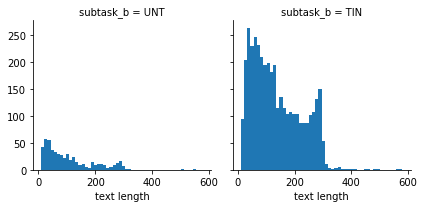

In [11]:
#Distribution over the length of the tweet
import seaborn as sns
import matplotlib.pyplot as plt
graph = sns.FacetGrid(data=df, col='subtask_b')
graph.map(plt.hist, 'text length', bins=50)

- a.	Distribution of text-length almost seem to be similar across all two classes
- b.	Number of tweets seem to be skewed a lot higher towards the class-NOT


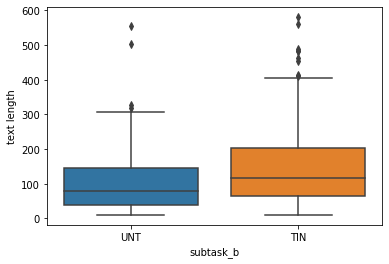

In [12]:
# Box-plot visualization
sns.boxplot(x='subtask_b', y='text length', data=df)

In [13]:
# collecting only the tweets from the csv file into a variable name tweet
tweet=df.tweet
tweet.head()

0    @USER She should ask a few native Americans wh...
1    @USER @USER Go home you’re drunk!!! @USER #MAG...
2    Amazon is investigating Chinese employees who ...
3    @USER Someone should'veTaken" this piece of sh...
4    @USER @USER Obama wanted liberals &amp; illega...
Name: tweet, dtype: object

# Preprocessing of the tweets

In [14]:
# Create our list of stopwords
stop_words = spacy.lang.en.stop_words.STOP_WORDS

#extending the stopwords to include other words used in twitter such as retweet(rt) etc.
#retweet, fav, follow friday

nlp.Defaults.stop_words |= {"#ff", "ff", "rt",}

In [15]:
def preprocess(tweet):  
    
    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ')

    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '')

    # removal of links[https://abc.com]
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '')
    # removal of punctuations and numbers
    punc_remove = tweets.str.replace("[^a-zA-Z]", " ") 
    # remove whitespace with a single space
    newtweet=punc_remove.str.replace(r'\s+', ' ')                   
    # remove leading and trailing whitespace 
    newtweet=newtweet.str.replace(r'^\s+|\s+?$','')
    # replace normal numbers with number  
    newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')
 
    # tokenizing
    tokenized_tweet = newtweet.apply(lambda x: x.split()) 
    
 
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        tweets_p= tokenized_tweet
    
    return tweets_p
   
processed_tweets = preprocess(tweet)

In [16]:
# Creating our tokenizer function
def spacy_tokenizer(processed_tweets):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(processed_tweets)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words ]

    # return preprocessed tokens
    return ' '.join(mytokens)

In [17]:
df = df.dropna(subset=['subtask_b']) # drop all the not relevant rows for Task B

In [18]:
%%time
df['final_tweet'] = processed_tweets.apply(lambda x: spacy_tokenizer(x))

CPU times: user 15min 33s, sys: 12 s, total: 15min 45s
Wall time: 15min 44s


Dataset after the preprocessing operation

In [19]:
df.head(10)

,id,tweet,subtask_a,subtask_b,subtask_c,text length,final_tweet
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,71,ask native americans
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,67,home drunk maga trump url
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,65,vetaken piece shit volcano
5,97670,@USER Liberals are all Kookoo !!!,OFF,TIN,OTH,33,liberal kookoo
6,77444,@USER @USER Oh noes! Tough shit.,OFF,UNT,NaN,32,oh noes tough shit
7,52415,@USER was literally just talking about this lo...,OFF,TIN,GRP,176,literally talk lol mass shooting like set s pr...
9,13384,@USER Canada doesn’t need another CUCK! We alr...,OFF,TIN,IND,138,canada doesn t need cuck looneyleft liberals f...
12,28414,@USER you are a lying corrupt traitor!!! Nobod...,OFF,TIN,IND,110,lie corrupt traitor want hear anymore lie deep...
19,28195,@USER @USER @USER gun control! That is all the...,OFF,TIN,OTH,69,gun control kid ask
20,56117,@USER @USER @USER @USER LOL!!! Throwing the ...,OFF,TIN,IND,141,lol throw bullshit flag nonsense putuporshutup...


In [20]:
final_tweet = df['final_tweet']

# Visualizations

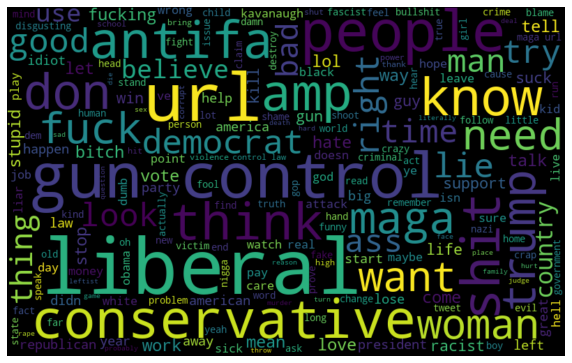

In [21]:
# visualizing which of the word is most commonly used in the twitter dataset

from wordcloud import WordCloud
all_words = ' '.join([text for text in df['final_tweet'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

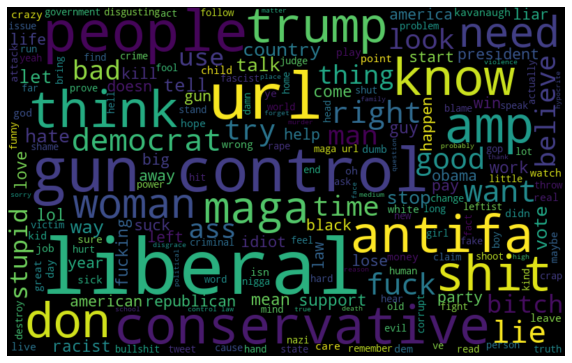

In [22]:
# visualizing which of the word is most commonly used for targeted offensive language


hatred_words = ' '.join([text for text in df['final_tweet'][df['subtask_b'] == "TIN"]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(hatred_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

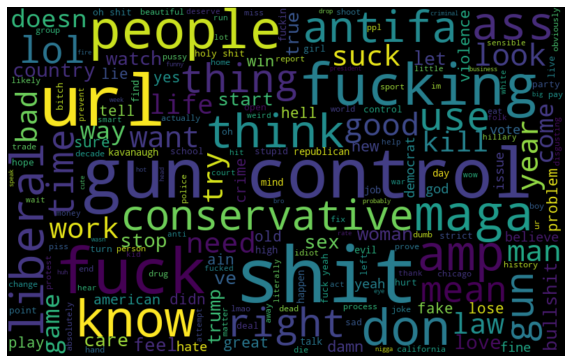

In [23]:
# visualizing which of the word is most commonly used for untargeted offensive language


offensive_words = ' '.join([text for text in df['final_tweet'][df['subtask_b'] == "UNT"]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(offensive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

# TF - IDF   Implementation

TF-IDF weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

**TF**: Term Frequency, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization:

* **TF**($t$) = (Number of times term $t$ appears in a document) / (Total number of terms in the document).

**IDF**: Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following:

* **IDF**($t$) = $log$(Total number of documents / Number of documents with term $t$ in it).

In [61]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_features=3500)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(final_tweet)
tfidf

<4400x3500 sparse matrix of type '<class 'numpy.float64'>'
	with 39497 stored elements in Compressed Sparse Row format>

In [62]:
X = tfidf # the features we want to analyze
y = df['subtask_b'].values # the labels

# Running the models Using TFIDF

We fit three models: Logistic Regression, Random Forest and XGB.

In [63]:
lr = LogisticRegression()
rf = RandomForestClassifier()
xgb = XGBClassifier()

In [64]:
%%time
clf = lr
train_lr_taskb = clf.fit(X,y)

CPU times: user 77.8 ms, sys: 981 µs, total: 78.8 ms
Wall time: 80 ms


In [65]:
%%time
clf = rf
train_rf_taskb = clf.fit(X,y)

CPU times: user 2.81 s, sys: 20.9 ms, total: 2.83 s
Wall time: 2.83 s


In [66]:
%%time
clf = xgb
train_xgb_taskb = clf.fit(X,y)

CPU times: user 838 ms, sys: 3.95 ms, total: 841 ms
Wall time: 841 ms


Read the test set and process as the training set (pre-processing + embedding with tf_idf)

In [67]:
#read test set A:
testseta = pd.read_csv("testset-levelb.tsv", sep='\t')

#extract tweet
tweet_seta=testseta.tweet
#preprocess
processed_tweets = preprocess(tweet_seta)

#tokenize tweet
tweet_seta['final_tweet'] = processed_tweets.apply(lambda x: spacy_tokenizer(x))
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

# TF-IDF feature matrix for tweet_seta
tfidf_a = tfidf_vectorizer.fit_transform(tweet_seta['final_tweet'])

Xa = tfidf_a # the features we want to analyze

Prediction using the models


In [68]:
predicted_lr=train_lr_taskb.predict(Xa)
predicted_rf=train_rf_taskb.predict(Xa)
predicted_xgb=train_xgb_taskb.predict(Xa)


Read the ground truth of the test set

In [69]:
expected_label= pd.read_csv("labels-levelb.csv",header=None, index_col=None)

formatted_el=[]
for i in range(len(expected_label)):
    formatted_el.append(expected_label.iloc[i][1])
    

# Evaluation

In [70]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [71]:
print("LR SCORES")

print("f1 macro score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_lr),average = 'macro')))#, pos_label="UNT")))

print("accuracy is: {} ".format(sklearn.metrics.accuracy_score((formatted_el),(predicted_lr))))

print("UNT")

print("f1 score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_lr),average = 'binary', pos_label="UNT")))

print("precision is: {} ".format(sklearn.metrics.precision_score((formatted_el),(predicted_lr), pos_label="UNT")))

print("recall is: {} ".format(sklearn.metrics.recall_score((formatted_el),(predicted_lr), pos_label="UNT")))

print("TIN")

print("f1 score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_lr),average = 'binary', pos_label="TIN")))

print("precision is: {} ".format(sklearn.metrics.precision_score((formatted_el),(predicted_lr), pos_label="TIN")))

print("recall is: {} ".format(sklearn.metrics.recall_score((formatted_el),(predicted_lr), pos_label="TIN")))


LR SCORES
f1 macro score is : 0.47019867549668876
accuracy is: 0.8875 
UNT
f1 score is : 0.0
precision is: 0.0 
recall is: 0.0 
TIN
f1 score is : 0.9403973509933775
precision is: 0.8875 
recall is: 1.0 


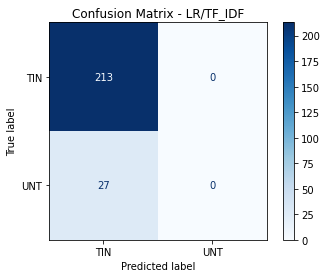

In [72]:
disp = plot_confusion_matrix(lr, Xa, formatted_el,
                             values_format='.0f', 
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix - LR/TF_IDF")
plt.show()

In [73]:
print("Random Forest Scores")

print("f1 macro score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_rf),average = 'macro')))#, pos_label="UNT")))

print("accuracy is: {} ".format(sklearn.metrics.accuracy_score((formatted_el),(predicted_rf))))

print("UNT")

print("f1 score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_rf),average = 'binary', pos_label="UNT")))

print("precision is: {} ".format(sklearn.metrics.precision_score((formatted_el),(predicted_rf), pos_label="UNT")))

print("recall is: {} ".format(sklearn.metrics.recall_score((formatted_el),(predicted_rf), pos_label="UNT")))

print("TIN")

print("f1 score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_rf),average = 'binary', pos_label="TIN")))

print("precision is: {} ".format(sklearn.metrics.precision_score((formatted_el),(predicted_rf), pos_label="TIN")))

print("recall is: {} ".format(sklearn.metrics.recall_score((formatted_el),(predicted_rf), pos_label="TIN")))


Random Forest Scores
f1 macro score is : 0.499964077879158
accuracy is: 0.8791666666666667 
UNT
f1 score is : 0.06451612903225806
precision is: 0.25 
recall is: 0.037037037037037035 
TIN
f1 score is : 0.9354120267260579
precision is: 0.8898305084745762 
recall is: 0.9859154929577465 


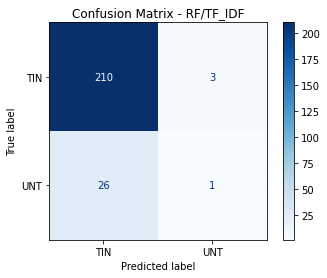

In [74]:
disp = plot_confusion_matrix(rf, Xa, formatted_el,
                             values_format='.0f', 
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix - RF/TF_IDF")
plt.show()

In [75]:
print("XGB Scores")

print("f1 macro score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_xgb),average = 'macro')))#, pos_label="UNT")))

print("accuracy is: {} ".format(sklearn.metrics.accuracy_score((formatted_el),(predicted_xgb))))

print("UNT")

print("f1 score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_xgb),average = 'binary', pos_label="UNT")))

print("precision is: {} ".format(sklearn.metrics.precision_score((formatted_el),(predicted_xgb), pos_label="UNT")))

print("recall is: {} ".format(sklearn.metrics.recall_score((formatted_el),(predicted_xgb), pos_label="UNT")))

print("TIN")

print("f1 score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_xgb),average = 'binary', pos_label="TIN")))

print("precision is: {} ".format(sklearn.metrics.precision_score((formatted_el),(predicted_xgb), pos_label="TIN")))

print("recall is: {} ".format(sklearn.metrics.recall_score((formatted_el),(predicted_xgb), pos_label="TIN")))


XGB Scores
f1 macro score is : 0.47019867549668876
accuracy is: 0.8875 
UNT
f1 score is : 0.0
precision is: 0.0 
recall is: 0.0 
TIN
f1 score is : 0.9403973509933775
precision is: 0.8875 
recall is: 1.0 


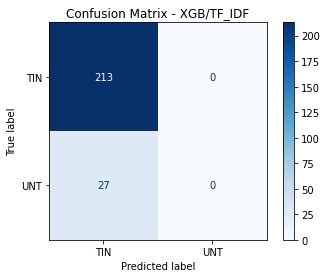

In [76]:
disp = plot_confusion_matrix(xgb, Xa, formatted_el,
                             values_format='.0f', 
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix - XGB/TF_IDF")
plt.show()

# Word2vec Implementation

* Word2vec groups the vector of similar words together in the vector space.
* That is it detects similarities mathematically.
* Given enough data, usage and contexts, word2vec can make highly accurate guesses about a word’s meaning based on past           appearances.
* Those guesses can be used to establish a word’s association with other words eg. “man” is to “boy” what “woman” is to “girl”.
* Each word is represented by a vector and in spaCy each vector has 300 dimensions [300 different properties associated,helpful while similarity matching]

In [37]:
def get_vec(x):
  doc = nlp(x)
  return doc.vector

In [38]:
new_dataset = df.drop(['subtask_b','tweet','text length'],axis = 1).copy()

In [39]:
%%time
new_dataset['vec'] = new_dataset['final_tweet'].apply(lambda x: get_vec(x))

CPU times: user 4min 58s, sys: 3.87 s, total: 5min 2s
Wall time: 5min 2s


In [40]:
XX = new_dataset['vec'].to_numpy()
XX = XX.reshape(-1,1)

In [41]:
XX = np.concatenate(np.concatenate(XX,axis = 0),axis = 0).reshape(-1,300)

In [42]:
yy = df['subtask_b'].values

# Running the models Using Word2vec

We fit three models: Logistic Regression, Random Forest and XGB.

In [43]:
lr1 = LogisticRegression()
rf1 = RandomForestClassifier()
xgb1 = XGBClassifier()

In [44]:
%%time
clf = lr1
train_lr1_taskb = clf.fit(XX,yy)


CPU times: user 358 ms, sys: 119 ms, total: 477 ms
Wall time: 270 ms


In [45]:
%%time
clf = rf1
train_rf1_taskb = clf.fit(XX,yy)

CPU times: user 8.26 s, sys: 102 ms, total: 8.36 s
Wall time: 8.25 s


In [46]:
%%time
clf = xgb1
train_xgb1_taskb = clf.fit(XX,yy)

CPU times: user 8.11 s, sys: 42.8 ms, total: 8.15 s
Wall time: 8.13 s


Read the test set and process as the training set (pre-processing + embedding with word2vec (implemented by spacy))

In [47]:
#read test set A:
new_testseta = pd.read_csv("testset-levelb.tsv", sep='\t')


#extract tweet
new_tweet_seta=new_testseta.tweet

#preprocess
processed_tweets = preprocess(new_tweet_seta)

#tokenize tweet
new_testseta['final_tweet'] = processed_tweets.apply(lambda x: spacy_tokenizer(x))
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

new_testseta['vec'] = new_testseta['final_tweet'].apply(lambda x: get_vec(x))

Xa = new_testseta.vec # the features we want to analyze

Xa = new_testseta['vec'].to_numpy()
Xa = Xa.reshape(-1,1)

Xa = np.concatenate(np.concatenate(Xa,axis = 0),axis = 0).reshape(-1,300)

Prediction using the models


In [48]:
predicted_lr1=train_lr1_taskb.predict(Xa)
predicted_rf1=train_rf1_taskb.predict(Xa)
predicted_xgb1=train_xgb1_taskb.predict(Xa)


Read the ground truth of the test set

In [49]:
expected_label= pd.read_csv("labels-levelb.csv",header=None,index_col=None)

formatted_el=[]
for i in range(len(expected_label)):
    formatted_el.append(expected_label.iloc[i][1])
    


# Evaluation

In [53]:
print("LR SCORES")

print("f1 macro score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_lr1),average = 'macro')))#, pos_label="UNT")))

print("accuracy is: {} ".format(sklearn.metrics.accuracy_score((formatted_el),(predicted_lr1))))

print("UNT")

print("f1 score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_lr1),average = 'binary', pos_label="UNT")))

print("precision is: {} ".format(sklearn.metrics.precision_score((formatted_el),(predicted_lr1), pos_label="UNT")))

print("recall is: {} ".format(sklearn.metrics.recall_score((formatted_el),(predicted_lr1), pos_label="UNT")))

print("TIN")

print("f1 score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_lr1),average = 'binary', pos_label="TIN")))

print("precision is: {} ".format(sklearn.metrics.precision_score((formatted_el),(predicted_lr1), pos_label="TIN")))

print("recall is: {} ".format(sklearn.metrics.recall_score((formatted_el),(predicted_lr1), pos_label="TIN")))


LR SCORES
f1 macro score is : 0.5689345498958259
accuracy is: 0.8958333333333334 
UNT
f1 score is : 0.19354838709677416
precision is: 0.75 
recall is: 0.1111111111111111 
TIN
f1 score is : 0.9443207126948776
precision is: 0.8983050847457628 
recall is: 0.9953051643192489 


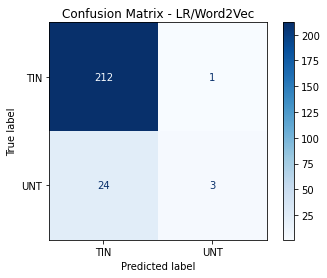

In [54]:
disp = plot_confusion_matrix(lr1, Xa, formatted_el,
                             values_format='.0f', 
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix - LR/Word2Vec")
plt.show()

In [55]:
print("Random Forest Scores")

print("f1 macro score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_rf1),average = 'macro')))#, pos_label="UNT")))

print("accuracy is: {} ".format(sklearn.metrics.accuracy_score((formatted_el),(predicted_rf1))))

print("UNT")

print("f1 score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_rf1),average = 'binary', pos_label="UNT")))

print("precision is: {} ".format(sklearn.metrics.precision_score((formatted_el),(predicted_rf1), pos_label="UNT")))

print("recall is: {} ".format(sklearn.metrics.recall_score((formatted_el),(predicted_rf1), pos_label="UNT")))

print("TIN")

print("f1 score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_rf1),average = 'binary', pos_label="TIN")))

print("precision is: {} ".format(sklearn.metrics.precision_score((formatted_el),(predicted_rf1), pos_label="TIN")))

print("recall is: {} ".format(sklearn.metrics.recall_score((formatted_el),(predicted_rf1), pos_label="TIN")))


Random Forest Scores
f1 macro score is : 0.5377777777777778
accuracy is: 0.8916666666666667 
UNT
f1 score is : 0.13333333333333333
precision is: 0.6666666666666666 
recall is: 0.07407407407407407 
TIN
f1 score is : 0.9422222222222223
precision is: 0.8945147679324894 
recall is: 0.9953051643192489 


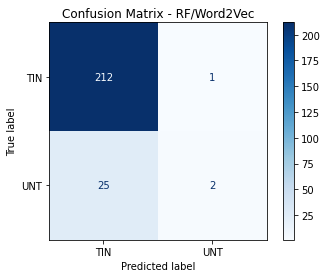

In [56]:
disp = plot_confusion_matrix(rf1, Xa, formatted_el,
                             values_format='.0f', 
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix - RF/Word2Vec")
plt.show()

In [57]:
print("XGB Scores")

print("f1 macro score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_xgb1),average = 'macro')))#, pos_label="UNT")))

print("accuracy is: {} ".format(sklearn.metrics.accuracy_score((formatted_el),(predicted_xgb1))))

print("UNT")

print("f1 score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_xgb1),average = 'binary', pos_label="UNT")))

print("precision is: {} ".format(sklearn.metrics.precision_score((formatted_el),(predicted_xgb1), pos_label="UNT")))

print("recall is: {} ".format(sklearn.metrics.recall_score((formatted_el),(predicted_xgb1), pos_label="UNT")))

print("TIN")

print("f1 score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_xgb1),average = 'binary', pos_label="TIN")))

print("precision is: {} ".format(sklearn.metrics.precision_score((formatted_el),(predicted_xgb1), pos_label="TIN")))

print("recall is: {} ".format(sklearn.metrics.recall_score((formatted_el),(predicted_xgb1), pos_label="TIN")))


XGB Scores
f1 macro score is : 0.5377777777777778
accuracy is: 0.8916666666666667 
UNT
f1 score is : 0.13333333333333333
precision is: 0.6666666666666666 
recall is: 0.07407407407407407 
TIN
f1 score is : 0.9422222222222223
precision is: 0.8945147679324894 
recall is: 0.9953051643192489 


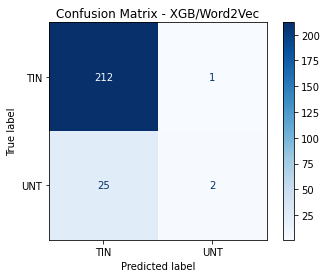

In [58]:
disp = plot_confusion_matrix(xgb1, Xa, formatted_el,
                             values_format='.0f', 
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix - XGB/Word2Vec")
plt.show()

# Model Explanation

In [59]:
!pip3 install eli5
import eli5

     |████████████████████████████████| 112kB 2.9MB/s 


In [77]:
eli5.show_weights(lr,vec=tfidf_vectorizer,top=15)  # logistic regression
# will give you top 15 features or words   


Weight?,Feature
+2.098,sooooo
+2.030,hear
+1.857,hear gun
+1.849,hatred awesome
+1.558,socialist
+1.468,jh woo
+1.457,kavanaugh
+1.361,universalcredit
+1.344,haven realize
+1.297,black live


In [78]:
eli5.show_weights(xgb,vec=tfidf_vectorizer,top=15)  # XGBoost
# will give you top 15 features or words   

Weight,Feature
0.0272,hatred awesome
0.0230,hear
0.0224,hear gun
0.0218,sooooo
0.0192,socialist
0.0191,live christmas
0.0180,mexico
0.0168,ago
0.0167,blame mom
0.0160,universalcredit


# Tweets Explanation

In [79]:
final_tweet[1]

'home drunk maga trump url'

In [80]:
eli5.show_prediction(rf ,vec = tfidf_vectorizer,doc =final_tweet[1]) 